# Basic Training Scheme development notebook

## Importing section

In [1]:
import torch
from torch import optim, nn
from torch.utils.data import random_split, DataLoader
from etnn.data.ferris_wheel import load_pure_ferris_wheel_dataset
from etnn.data.tree_structure import TreeNode
from etnn.nn.layer_framework import LayerManagementFramework
from tqdm import tqdm
import matplotlib.pyplot as plt
from etnn.tools.training import train_epoch, eval_epoch
from etnn.tools.training_tools import EpochControl, ConfigStore, AccuracyManager

In [2]:
import numpy as np
import pandas as pd
import os

## Parameter definition

In [3]:
NUM_GONDOLAS = 10
NUM_PART_PG = 5
DATASET_SIZE = 10_000
DATASET_PATH = "../datasets"

In [4]:
val_perc = 0.1
test_perc = 0.2

In [5]:
SAVING_PATH = "."
MODEL_SAVING_NAME = "model.pt"

In [6]:
CONFIG_SAVING_NAME = "config.json"
ACCURACY_SAVING_NAME = "accuracies.csv"
RESULTS_FOLDER = "."

In [7]:
# todo: take care of None values as representing not yet implemented features
config = ConfigStore(
    in_dim=15,
    hidden_dim=32,
    out_dim=1,
    k=2,
    is_accuracy_score=False,
    which_score=None,
    loss_name=None,
    optimizer_name=None,
    num_max_epochs=20,
    learning_rate=0.001,
    batch_size=32,
    early_stop_tol=5,
    is_classification=False
)

## data preparation

In [8]:
dataset = load_pure_ferris_wheel_dataset(
    num_gondolas=NUM_GONDOLAS,
    num_part_pg=NUM_PART_PG,
    num_to_generate=DATASET_SIZE,
    dataset_path=DATASET_PATH
)

In [9]:
len(dataset)

10000

In [10]:
generator = torch.Generator().manual_seed(420)
train_ds, val_ds, test_ds = random_split(
    dataset,
    [1-val_perc-test_perc, val_perc, test_perc],
    generator=generator
)

In [11]:
train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=config.batch_size, shuffle=False)

In [12]:
# todo: add more tree mutated sequences that are in dataset
# todo: add some faulty sequences which disturb this and see how much this affects the training

## Build tree structure

In [13]:
tree_structure = TreeNode(
    node_type="C",
    children=[
        TreeNode("P", [TreeNode("E", NUM_PART_PG)])
        for _ in range(NUM_GONDOLAS)
    ]
)

## Define device

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
device = 'cpu'

In [16]:
device

'cpu'

## Define Model

In [17]:
model = LayerManagementFramework(
    in_dim=config.in_dim,
    tree=tree_structure,
    hidden_dim=config.hidden_dim,
    out_dim=config.out_dim,
    k=config.k
).to(device)

## Define Loss and Optimizers

In [18]:
criterion = nn.MSELoss()

In [19]:
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)

## Training

In [20]:
# init loss history
loss_history_train = []
loss_history_test = []

In [21]:
epoch_control = EpochControl(
    model_save_name=MODEL_SAVING_NAME,
    config_save_name=CONFIG_SAVING_NAME,
    saving_folder_path=SAVING_PATH,
    tolerance=config.early_stop_tol,
    is_accuracy_score=config.is_accuracy_score
)

In [22]:
accuracy_protocoller = AccuracyManager(
    storage_name=ACCURACY_SAVING_NAME,
    storage_path=RESULTS_FOLDER,
    is_classification=False
)

In [23]:
# train for N epochs
for epoch in tqdm(range(config.num_max_epochs)):
    mean_train_loss, train_true_y, train_pred_y = train_epoch(
        model,
        train_loader,
        optimizer,
        device,
        criterion
    )

    loss_history_train += [mean_train_loss]

    mean_test_loss, test_true_y, test_pred_y = eval_epoch(
        model,
        test_loader,
        device,
        criterion
    )
    loss_history_test += [mean_test_loss]

    # use accuracy manager to calc accuracy metrics and save them
    accuracy_protocoller.calc_and_collect(
        config_id="t1",
        epoch=epoch+1,
        train_y_true=train_true_y,
        train_y_pred=train_pred_y,
        train_loss=mean_train_loss,
        test_y_true=test_true_y,
        test_y_pred=test_pred_y,
        test_loss=mean_test_loss,
    )

    # check if model is better and save it
    if epoch_control.retain_best_and_stop(model, mean_train_loss, mean_test_loss, config):
        break

  5%|▌         | 1/20 [00:06<02:02,  6.44s/it]

++save++


 10%|█         | 2/20 [00:12<01:54,  6.36s/it]

++save++


 35%|███▌      | 7/20 [00:50<01:34,  7.23s/it]


In [24]:
df_measures = pd.read_csv(os.path.join(SAVING_PATH, ACCURACY_SAVING_NAME))
df_measures

,config_id,epoch,train_loss,val_loss,test_loss,train_mse,train_msa,train_explained_variance,train_r2,val_mse,val_msa,val_explained_variance,val_r2,test_mse,test_msa,test_explained_variance,test_r2
0,t1,1,202.421707,0.0,48.323750,202.606354,7.256763,-5.657529,-5.688306,0.0,0.0,0.0,0.0,48.429790,5.502518,-0.175787,-0.623439
1,t1,2,46.658604,0.0,35.522301,46.660671,5.445219,-0.539951,-0.540331,0.0,0.0,0.0,0.0,35.612217,4.716859,-0.193176,-0.193775
2,t1,3,52.403801,0.0,36.036114,52.418858,5.788526,-0.730233,-0.730416,0.0,0.0,0.0,0.0,36.129070,4.742094,-0.189231,-0.211100
3,t1,4,45.022682,0.0,35.585258,45.033497,5.368131,-0.486275,-0.486616,0.0,0.0,0.0,0.0,35.676170,4.716181,-0.190415,-0.195918
4,t1,5,45.537930,0.0,38.334793,45.541927,5.378829,-0.503195,-0.503400,0.0,0.0,0.0,0.0,38.415211,4.973010,-0.200757,-0.287735
5,t1,6,46.114811,0.0,43.899067,46.116821,5.418031,-0.522024,-0.522378,0.0,0.0,0.0,0.0,43.972374,5.387838,-0.207290,-0.474020
6,t1,7,43.358871,0.0,63.038383,43.341820,5.262133,-0.430646,-0.430771,0.0,0.0,0.0,0.0,63.151718,6.399624,-0.163381,-1.116940
7,t1,8,41.555824,0.0,44.175789,41.563652,5.143557,-0.371637,-0.372071,0.0,0.0,0.0,0.0,44.249416,5.407692,-0.207332,-0.483307


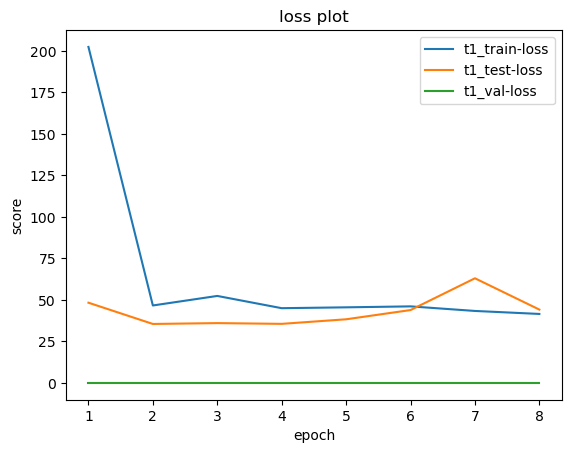

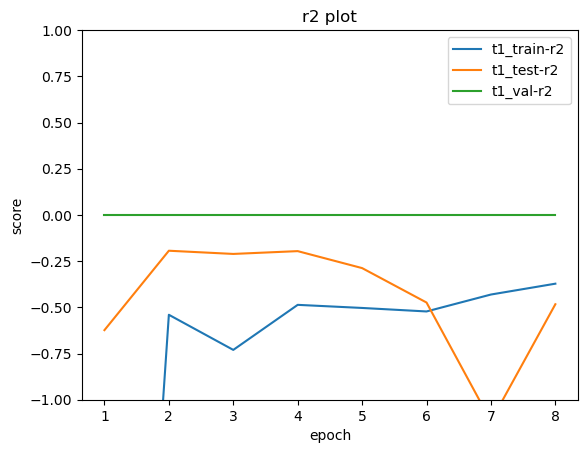

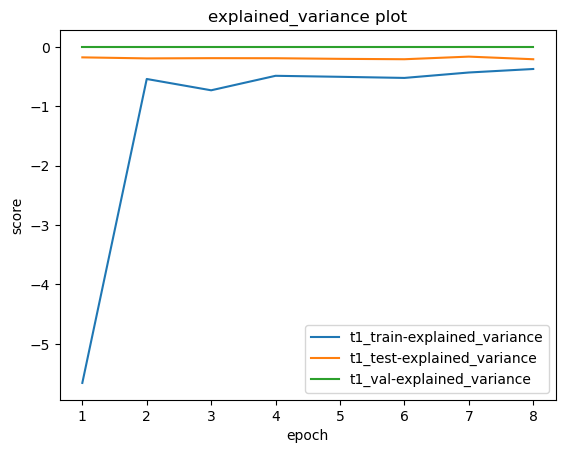

In [25]:
for what in ['loss', 'r2', 'explained_variance']:
    plt.figure()
    for config_id in df_measures.config_id.unique():
        # make subdataset for config id
        sub_df = df_measures[df_measures.config_id == config_id]

        # plot train test and val
        for mode in ['train', 'test', 'val']:
            # plot training
            plt.plot(sub_df.epoch, sub_df[f"{mode}_{what}"], label=f"{config_id}_{mode}-{what}")

    plt.title(f"{what} plot")
    plt.xlabel("epoch")
    plt.ylabel("score")
    if what == 'r2':
        plt.ylim(-1,1)
    plt.legend()
    plt.show()

In [26]:
# plot explained variances

In [27]:
# plot r2

In [28]:
test_loss = torch.nn.CrossEntropyLoss()

In [29]:
label = torch.tensor([0., 1.,2.,3.,4.])
pred = torch.tensor([1.1, 1., 2., 2., 4.])

In [30]:
test_loss(pred, label)

tensor(16.1880)

todo:
- build option for classification instead of regression
- either still predict number or make softmax classification

## Test/Debug

with open("test1.txt", "w") as file:
    file.write("config_id, epoch\n")
    file.write("0,1")

with open("test1.txt", "a") as file:
    file.write(f"\n")

import pandas as pd

pd.read_csv("test1.txt")

for x,y in train_loader:
    break

x.shape

x

y.shape

y

for i in range(1000):
    optimizer.zero_grad()
    prediction = model(x).flatten()
    loss = criterion(prediction, y)
    print(f"Epoch:{i+1} - loss:{loss}")
    loss.backward()
    optimizer.step()

y

model(x).flatten()